In [1]:
import numpy as np
from numpy.linalg import inv
from numpy import matmul
import matplotlib.pyplot as plt
from scipy.sparse import diags as sdiags
import itertools
from tqdm import tqdm

# 1D

In [2]:
def mesh(t, x):
    t0, tf, dt = t[0], t[1], t[2]
    x0, xf, dx = x[0], x[1], x[2]
    mu = dt/(dx * dx)
    x = np.linspace(x0, xf, int((xf - x0)/dx) + 1)
    t = np.linspace(t0, tf, int((tf - t0)/dt) + 1)

    xx, tt = np.meshgrid(x, t)
    u = np.zeros_like(xx)
    u[0, :] = initial_cond(x)
    u[:, 0] = 0
    u[:, -1] = 0
    return u, xx, mu



In [3]:
def initial_cond(x):
    return 150 * (-0.5 + np.random.randn(x.size))

In [4]:
def pot(x):
#     return np.zeros_like(x)
    return 0.5*((x)**2)

In [5]:
def normalizer(x, dx):
    n = np.sqrt(np.trapz(x**2, dx=dx))
    return x/n

In [6]:
def matrix(mu, u, pot):
    ll = u
    maindiag = np.zeros(ll)
    maindiag[:] = 1+0.5*mu
    subdiag = np.zeros(ll-1)
    subdiag[:] = -mu
    A = sdiags([maindiag, subdiag, subdiag], [0,1,-1]).toarray()

    maindiag2 = np.zeros_like(maindiag)
    maindiag2[:] = 1-0.5*mu + 4*pot

    B = sdiags([maindiag2, -subdiag, -subdiag], [0,1,-1]).toarray()
    return inv(A), B

    

In [7]:
def solver(u, mu, A, B, DL, DR):
    sol = matmul(A, B)
    bj = np.zeros_like(u)
    bj[0] = mu*DL ; bj[-1] = mu*DR
    # bj1[0] = mu*DL ; bj[-1] = mu*DR

    v = matmul(sol, u) + bj
    return v

In [8]:
def cn(mesh, mu ,DL, DR, h, func_pot=None):
    pot = None
    if func_pot is not None:
        pot = func_pot

    def energy(psi, h, pot=None):
        if pot is None:
            pot = np.zeros_like(psi)
        psi_sqr = np.sum(psi * psi)
        nn = np.sum(psi_sqr)
        




    ener = np.zeros(mesh.shape[0])
    

    mat1, mat2 = matrix(mu, mesh.shape[1], pot=pot)
    for i in tqdm(range(mesh.shape[0] - 1)):
        mesh[i+1, :] = solver(mesh[i, :], mu, mat1, mat2, DL, DR)
        mesh[i+1, :] = normalizer(mesh[i+1, :], h)
    return mesh


In [9]:
t = (0., 1., 1e-5)
x = (-10., 10., 1e-1)


In [10]:
u, grid, mu = mesh(t, x)

In [12]:
potential = pot(grid[-1])

In [13]:
final = cn(u, mu, 0, 0, x[-1], func_pot=potential)


100%|██████████████████████████████████████████████████████████████████████████| 99999/99999 [00:37<00:00, 2632.71it/s]


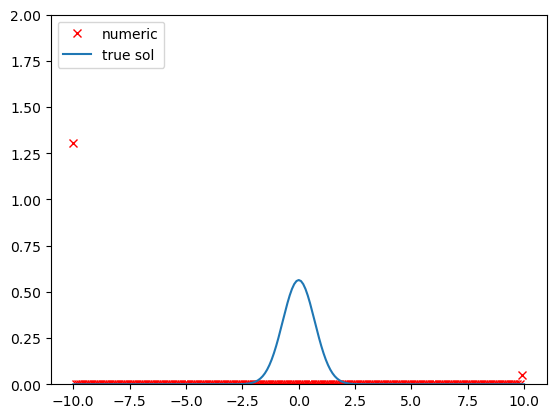

In [14]:
plt.plot(grid[-1], final[-1]**2, 'rx', label="numeric")
# plt.plot(grid[-1], (np.sqrt(2)*np.sin(np.pi*grid[-1]))**2, label="true sol")
plt.plot(grid[-1], np.exp(-1.0 * grid[-1] * grid[-1]) / np.sqrt(np.pi), label="true sol")
plt.legend()
plt.ylim(0, 2)
plt.show()